## Predicting Rain with Machine Learning

## 자료 출처
https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

## 분석 내용
특정 지역의 과거 날씨 데이터를 이용해 앞으로 며칠 동안의 날씨를 예측하자

Using historical weather information from their region, can you predict what the weather will be like in the next few days?

### The data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
region_A_test = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_A_test.csv")
region_A_test

,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9
...,...,...,...,...,...,...,...,...,...,...,...
373,01a1b150,9.3,11.6,7.5,0.0,0.9,3.3,S,4.8,S,1013.4
374,90b49549,9.6,18.6,2.9,0.0,1.5,6.8,SW,8.4,S,1023.0
375,15bc4979,9.7,11.5,8.2,9.0,1.1,4.3,NW,6.6,W,1017.7
376,b4104846,12.6,20.2,8.7,10.0,1.7,5.5,NE,8.3,E,1011.0


In [ ]:
solution_format = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/solution_format.csv")
solution_format

,date,label
0,b92d713a,L
1,18817005,N
2,8e19dc3c,L
3,6f0929dc,H
4,c7506622,L
...,...,...
373,01a1b150,L
374,90b49549,N
375,15bc4979,L
376,b4104846,N


+ Labels : N(No rain), L(Light rain), H(Heavy rain)

### Installing libraries and models

### Load Libraries

In [ ]:
# %pip install lightgbm

In [ ]:
# essentials
import numpy as np
import pandas as pandas

In [ ]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc = {'figure.figsize' : (11.7, 8.27)})
sns.set(style = "whitegrid")
%matplotlib inline

In [ ]:
# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

In [ ]:
# 사용자 정의함수
def print_col_type(df):
  non_num_df = df.select_dtypes(include = ['object'])
  num_df = df.select_dtypes(exclude = ['object'])
  '''separates non-numeric and numeric columns'''
  print("Object columns : ")
  for col in non_num_df:
      print(f"{col}")
  print("")
  print("Numeric columns:")
  for col in num_df:
      print(f"{col}")

In [ ]:
def missing_cols(df):
  '''prints out columns with its amount of missing values with its %'''
  total = 0
  for col in df.columns:
      missing_vals = df[col].isnull().sum()
      pct = df[col].isna().mean() * 100
      total += missing_vals
      if missing_vals != 0:
        print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
  if total == 0:
      print("no missing values")

### Load the data

In [ ]:
train_a = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/region_A_train.csv")
train_b = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/region_B_train.csv")
train_c = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/region_C_train.csv")
train_d = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/region_D_train.csv")
train_e = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/region_E_train.csv")

In [ ]:
test_a = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_A_test.csv")
test_b = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_B_test.csv")
test_c = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_C_test.csv")
test_d = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_D_test.csv")
test_e = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_test/region_E_test.csv")

In [ ]:
labels_df = pd.read_csv("/content/drive/MyDrive/22-1 기계학습 실습/22-1 기계학습 과제/Dataset/comp_datasets_train/solution_train.csv")

### Exploratory Data Analysis

#### about train

In [ ]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [ ]:
train_all = pd.concat([train_a, train_b, train_c, train_d, train_e], keys = ["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [ ]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0" : "region"}, inplace = True)
train_all_lvls.drop(columns = ['level_1'], inplace = True)
train_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2825,E,91b2797d,6.3,13.1,0.3,0.0,0.6,2.2,S,4.3,S,NaN
2826,E,b807fd87,6.2,13.5,0.3,0.0,0.8,2.3,SW,6.3,W,NaN
2827,E,8e0a48e0,9.0,15.9,2.4,0.0,0.6,2.4,NW,5.7,W,NaN
2828,E,9df85983,5.3,13.9,0.1,0.0,1.0,3.0,S,6.9,NW,NaN


#### about test

In [ ]:
test_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     378 non-null    object 
 1   avg.temp                 378 non-null    float64
 2   max.temp                 378 non-null    float64
 3   min.temp                 378 non-null    float64
 4   precipitation            378 non-null    float64
 5   avg.wind.speed           378 non-null    float64
 6   max.wind.speed           378 non-null    float64
 7   max.wind.speed.dir       378 non-null    object 
 8   max.inst.wind.speed      378 non-null    float64
 9   max.inst.wind.speed.dir  378 non-null    object 
 10  min.atmos.pressure       378 non-null    float64
dtypes: float64(8), object(3)
memory usage: 32.6+ KB


In [ ]:
test_all = pd.concat([test_a, test_b, test_c, test_d, test_e], keys = ["A", "B", "C", "D", "E"])
test_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    b92d713a       5.0      11.9       0.7            0.0             3.6   
  1    18817005       2.9       9.1      -1.8            0.0             3.4   
  2    8e19dc3c       9.8      18.9       0.4            0.0             3.1   
  3    6f0929dc      13.4      21.2       6.1            0.0             3.4   
  4    c7506622       9.1      16.3       2.4            0.0             2.7   
...         ...       ...       ...       ...            ...             ...   
E 373  01a1b150       6.9       9.5       4.3            1.5             0.3   
  374  90b49549       6.5      15.8      -0.1            0.0             0.6   
  375  15bc4979       7.9      10.3       3.5            9.5             0.3   
  376  b4104846       9.1      17.1       4.9           11.0             0.6   
  377  28c40b9c       7.0      17.1       0.6            0.0             0.8   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0              11.9                 NW                 16.7   
  1               9.6                 SW                 15.4   
  2               8.9                  W                 13.6   
  3               8.8                 SW                 13.8   
  4               7.6                 NW                 11.9   
...               ...                ...                  ...   
E 373             1.2                  S                  2.7   
  374             2.2                 SE                  4.7   
  375             1.7                 SW                  5.8   
  376             2.1                 SW                  5.8   
  377             2.8                  S                  5.2   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                        NW              1009.2  
  1                        SW              1013.6  
  2                         W              1002.6  
  3                        SW              1003.1  
  4                        NW              1011.9  
...                       ...                 ...  
E 373                      SE                 NaN  
  374                       S                 NaN  
  375                       S                 NaN  
  376                      NW                 NaN  
  377                       S                 NaN  

[1890 rows x 11 columns]

In [ ]:
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0" : "region"}, inplace = True)
test_all_lvls.drop(columns = ['level_1'], inplace = True)
test_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9
...,...,...,...,...,...,...,...,...,...,...,...,...
1885,E,01a1b150,6.9,9.5,4.3,1.5,0.3,1.2,S,2.7,SE,NaN
1886,E,90b49549,6.5,15.8,-0.1,0.0,0.6,2.2,SE,4.7,S,NaN
1887,E,15bc4979,7.9,10.3,3.5,9.5,0.3,1.7,SW,5.8,S,NaN
1888,E,b4104846,9.1,17.1,4.9,11.0,0.6,2.1,SW,5.8,NW,NaN


### Distribution of target class

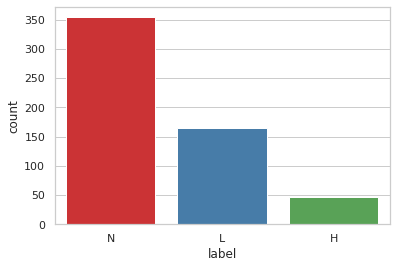

In [ ]:
sns.countplot(x = "label", data = labels_df, palette = "Set1")

+ 레이블 N이 나머지에 비해 꽤 많은 빈도를 차지하여 **"불균형 데이터"** 임을 확인할 수 있음
+ 불균형 데이터의 문제 : 분류기가 더 많은 표본이 있는 범주에 대해 강하게, 더 적은 표본이 있는 범주에 대해 약하게 예측하는 방법을 학습하게 됨
+ 이 상황에서는 레이블 N이 다른 범주에 비해 더 많이 예측될 것임을 보임


### Plotting the features

#### about train

In [ ]:
train_all_lvls.columns[2:]   # x변수가 10개

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

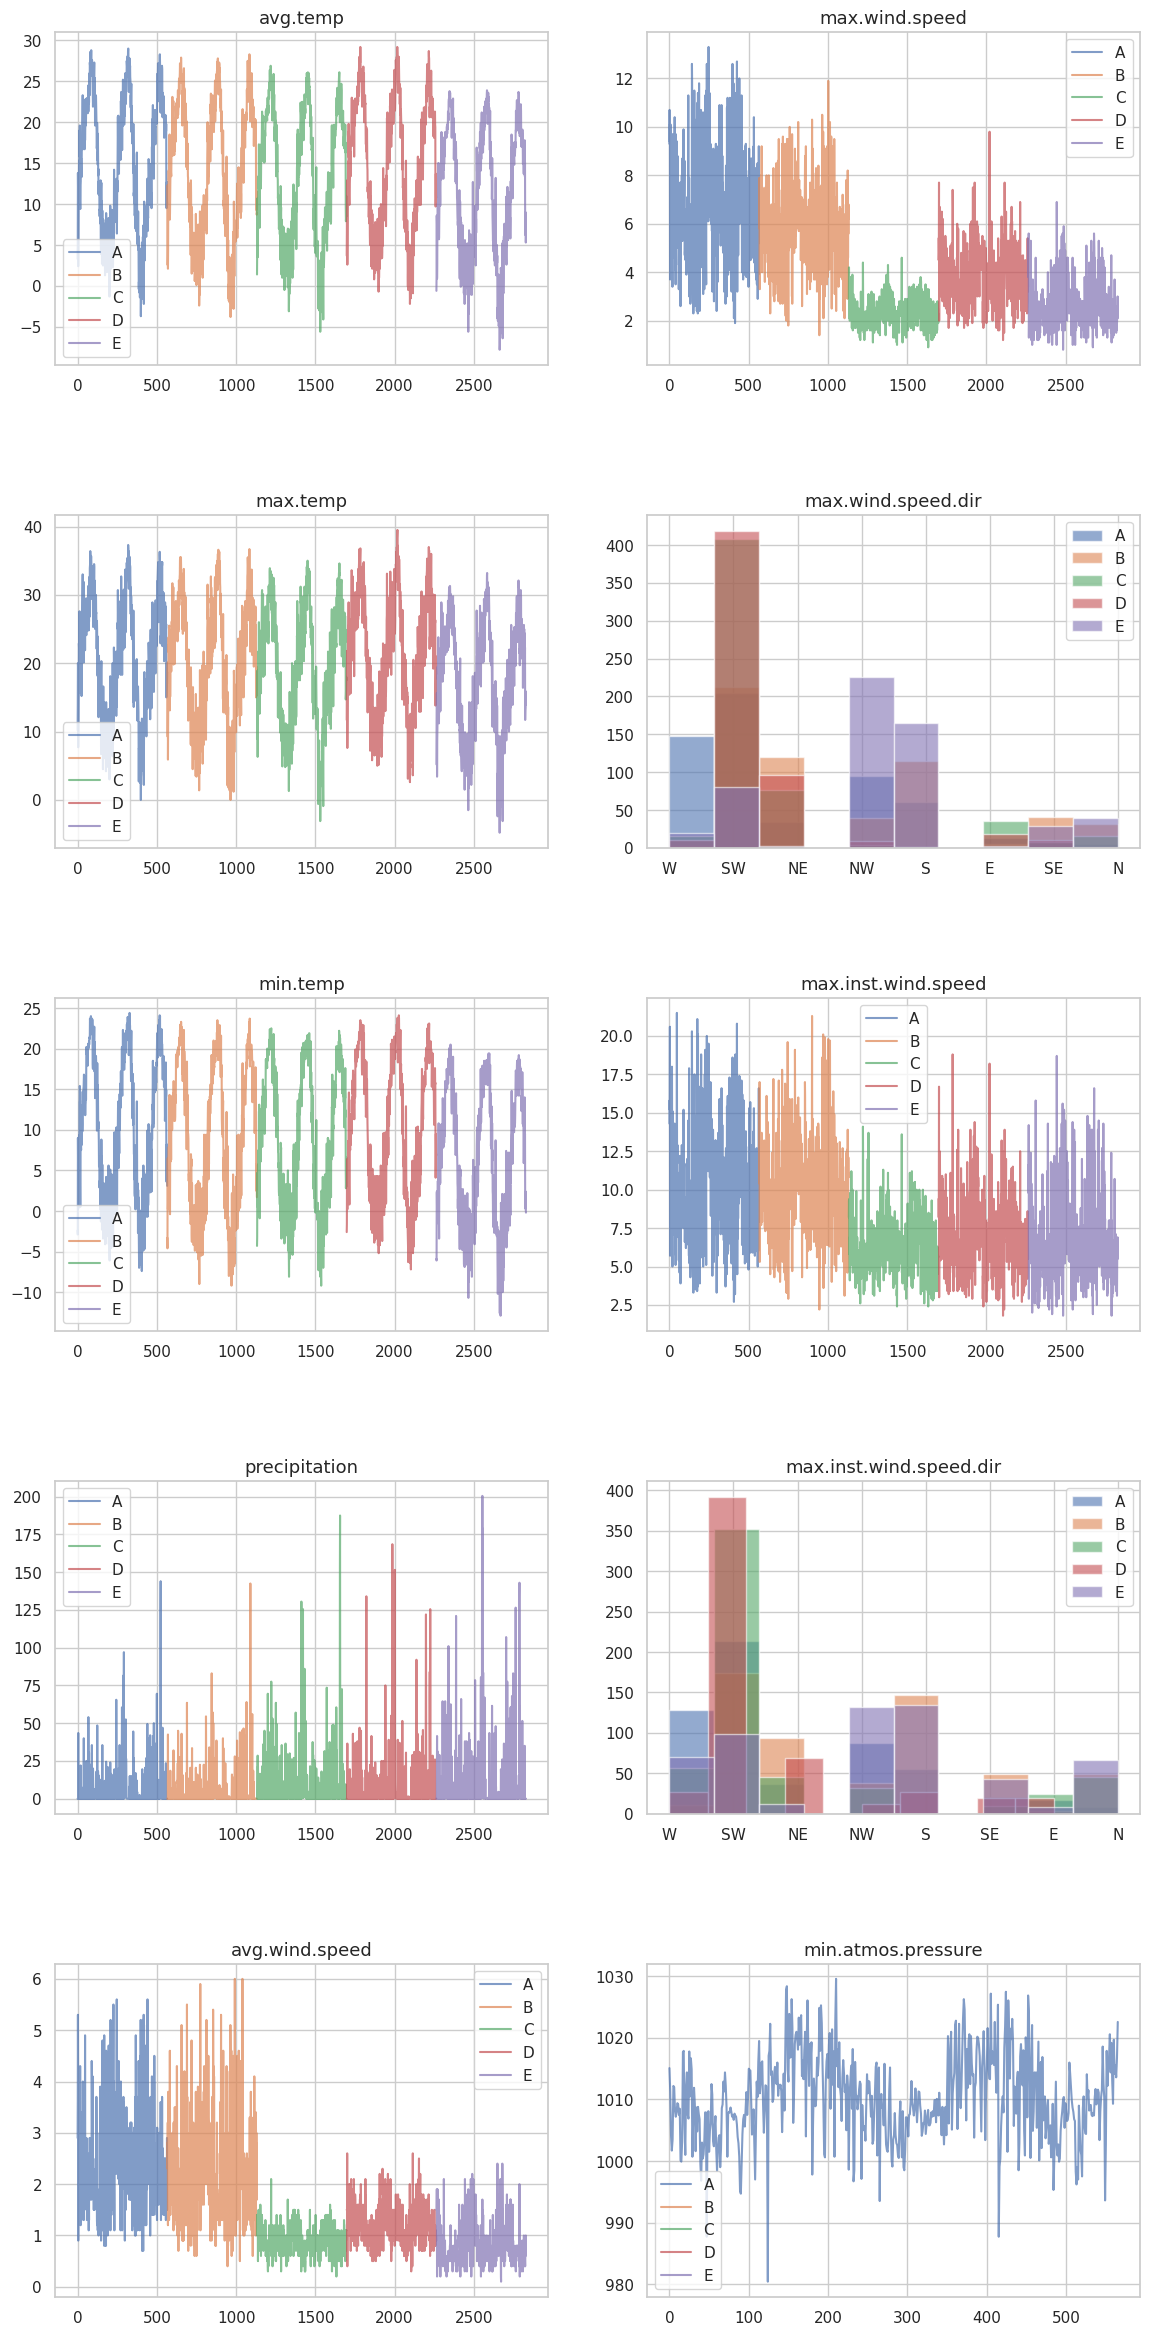

In [ ]:
fig, axes = plt.subplots(5, 2, figsize = (14, 30), dpi = 100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

#### about test

In [ ]:
test_all_lvls.columns[2:]   # x변수가 10개

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

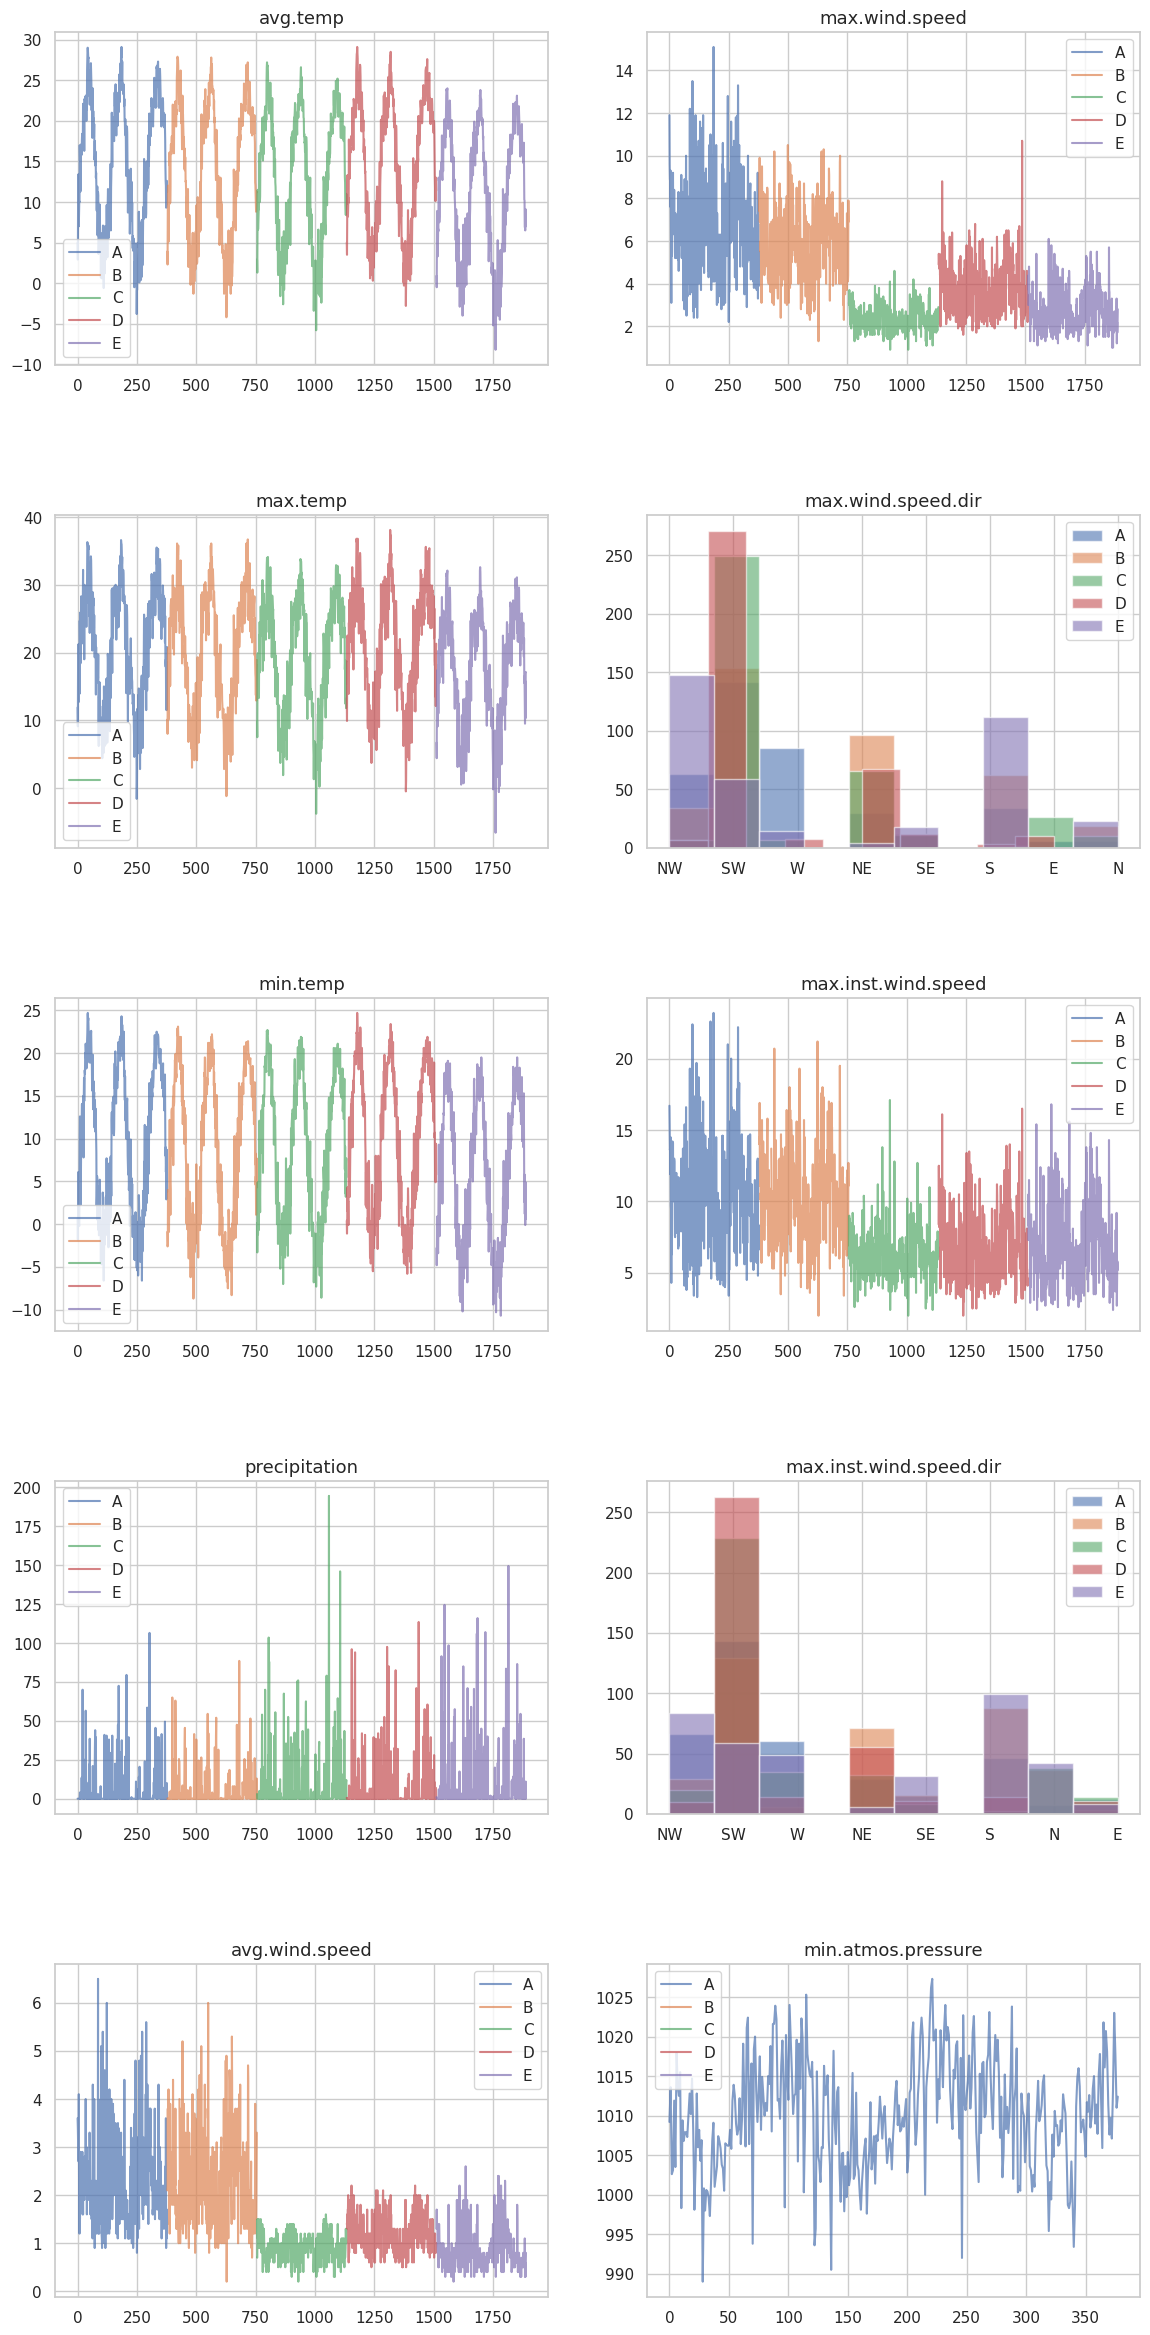

In [ ]:
fig, axes = plt.subplots(5, 2, figsize = (14, 30), dpi = 100)

for i, col_name in enumerate(test_all_lvls.columns[2:]):
    if test_all_lvls[col_name].dtype == 'O':
        test_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        test_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

### Missing values

#### about train

#### 결측치 처리 전

In [ ]:
missing_cols(train_all_lvls)

min.atmos.pressure => 2264 [80.0%]


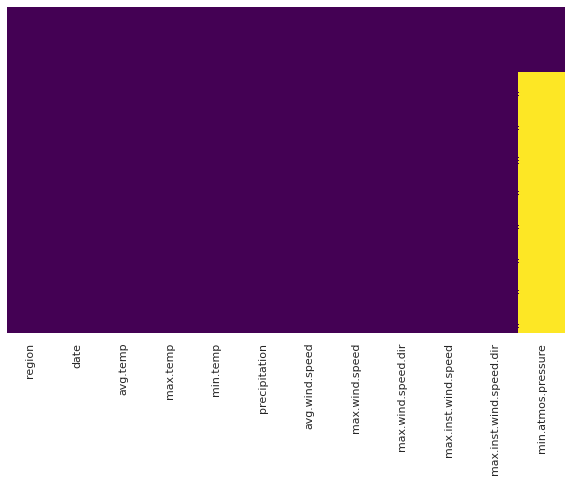

In [ ]:
plt.figure(figsize = (10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels = False, cmap = "viridis", cbar = False)

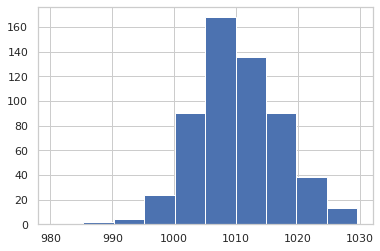

In [ ]:
train_all_lvls["min.atmos.pressure"].hist()

In [ ]:
mean_atmos = train_all_lvls["min.atmos.pressure"].mean()
train_all_lvls.fillna(mean_atmos, inplace = True)

#### 결측치 처리 후

In [ ]:
missing_cols(train_all_lvls)

no missing values


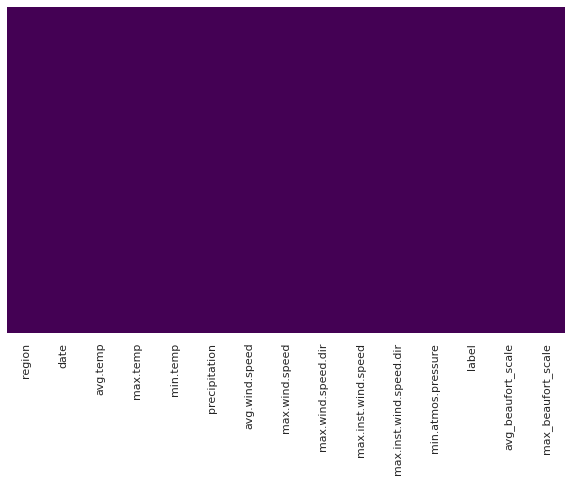

In [ ]:
plt.figure(figsize = (10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels = False, cmap = "viridis", cbar = False)

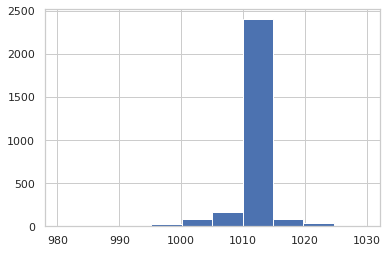

In [ ]:
train_all_lvls["min.atmos.pressure"].hist()

#### about test

#### 결측치 처리 전

In [ ]:
missing_cols(test_all_lvls)

avg.temp => 2 [0.11%]
max.temp => 2 [0.11%]
min.temp => 2 [0.11%]
precipitation => 2 [0.11%]
avg.wind.speed => 2 [0.11%]
max.wind.speed => 2 [0.11%]
max.inst.wind.speed => 2 [0.11%]
min.atmos.pressure => 1512 [80.0%]


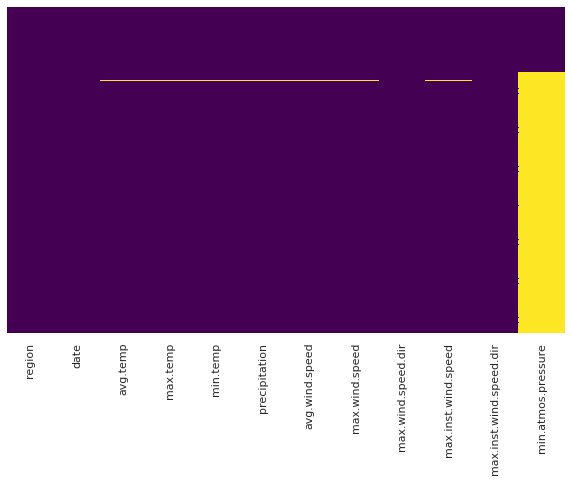

In [ ]:
plt.figure(figsize = (10, 6))
sns.heatmap(test_all_lvls.isnull(), yticklabels = False, cmap = "viridis", cbar = False)

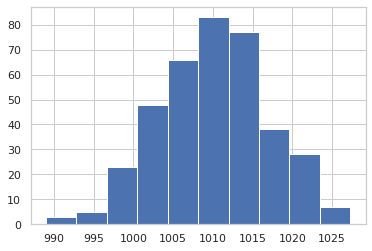

In [ ]:
test_all_lvls["min.atmos.pressure"].hist()

In [ ]:
mean_atmos = test_all_lvls["min.atmos.pressure"].mean()
test_all_lvls.fillna(mean_atmos, inplace = True)

#### 결측치 처리 후

In [ ]:
missing_cols(test_all_lvls)

no missing values


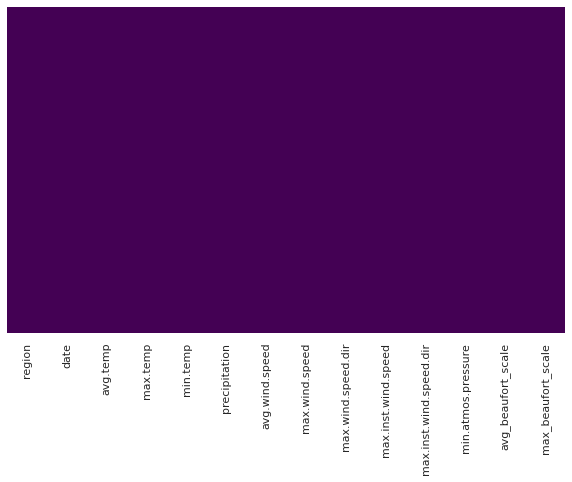

In [ ]:
plt.figure(figsize = (10, 6))
sns.heatmap(test_all_lvls.isnull(), yticklabels = False, cmap = "viridis", cbar = False)

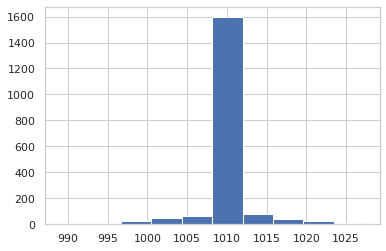

In [ ]:
test_all_lvls["min.atmos.pressure"].hist()

### Feature Preprocessing & Engineering

#### about train

In [ ]:
train_all_lvls = train_all_lvls.merge(labels_df, on = "date")

In [ ]:
train_all_lvls.select_dtypes("object").columns  # 범주형 변수

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

In [ ]:
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [ ]:
BEAUFORT = [
            (0, 0, 0.3),
            (1, 0.3, 1.6),
            (2, 1.6, 3.4),
            (3, 3.4, 5.5),
            (4, 5.5, 8),
            (5, 8, 10.8),
            (6, 10.8, 13.9),
            (7, 13.9, 17.2),
            (8, 17.2, 20.8),
            (9, 20.8, 24.5),
            (10, 24.5, 28.5),
            (11, 28.5, 33),
            (12, 33, 200),
]

def feature_eng(df):
  le = LabelEncoder()

  cat_cols = df.select_dtypes("object").columns[2 : ]

  for col in cat_cols:
    if df[col].dtype == "object":
      df[col] = le.fit_transform(df[col])

    # wind speed is in meter / second
    # convert to knots to obtain beaufort scale
    for item in BEAUFORT:
      df.loc[
             (df["max.wind.speed"] * 1.944 >= item[1]) & (df["avg.wind.speed"] * 1.944 < item[2]),
             "avg_beaufort_scale",
      ] = item[0]
      df.loc[
             (df["max.wind.speed"] * 1.944 >= item[1]) & (df["max.wind.speed"] * 1.944 < item[2]),
            "max_beaufort_scale",
      ] = item[0]

      df["avg_beaufort_scale"] = df["avg_beaufort_scale"].astype(int)
      df["max_beaufort_scale"] = df["max_beaufort_scale"].astype(int)

      return df

In [ ]:
train = feature_eng(train_all_lvls)

In [ ]:
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure,label,avg_beaufort_scale,max_beaufort_scale
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,7,14.3,7,1015.100000,N,1010,1010
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,3,11.4,3,1010.216254,N,1010,1010
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,6,8.2,1,1010.216254,N,1010,1010
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,6,9.4,4,1010.216254,N,1010,1010
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,3,9.8,7,1010.216254,N,1010,1010


In [ ]:
train = train.pivot_table(index = ["date", "label"], columns = "region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,00173aec,N,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,L,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,N,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,N,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,N,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0


In [ ]:
def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
      text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [ ]:
train.columns = list(map(replace_all, train.columns))

In [ ]:
train.columns

Index(['date', 'label', 'avg.temp_A', 'avg.temp_B', 'avg.temp_C', 'avg.temp_D',
       'avg.temp_E', 'avg.wind.speed_A', 'avg.wind.speed_B',
       'avg.wind.speed_C', 'avg.wind.speed_D', 'avg.wind.speed_E',
       'avg_beaufort_scale_A', 'avg_beaufort_scale_B', 'avg_beaufort_scale_C',
       'avg_beaufort_scale_D', 'avg_beaufort_scale_E', 'max.inst.wind.speed_A',
       'max.inst.wind.speed_B', 'max.inst.wind.speed_C',
       'max.inst.wind.speed_D', 'max.inst.wind.speed_E',
       'max.inst.wind.speed.dir_A', 'max.inst.wind.speed.dir_B',
       'max.inst.wind.speed.dir_C', 'max.inst.wind.speed.dir_D',
       'max.inst.wind.speed.dir_E', 'max.temp_A', 'max.temp_B', 'max.temp_C',
       'max.temp_D', 'max.temp_E', 'max.wind.speed_A', 'max.wind.speed_B',
       'max.wind.speed_C', 'max.wind.speed_D', 'max.wind.speed_E',
       'max.wind.speed.dir_A', 'max.wind.speed.dir_B', 'max.wind.speed.dir_C',
       'max.wind.speed.dir_D', 'max.wind.speed.dir_E', 'max_beaufort_scale_A',
       'max

In [ ]:
train

,date,label,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,N,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,L,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,N,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,N,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,N,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,L,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,L,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,L,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,N,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


In [ ]:
X, y = train.drop(["label", "date"], axis = 1), train[["label"]].values.flatten()

# Extract categoricals and their indices
cat_feats = X.select_dtypes(include = ['int64']).columns.to_list()
cat_idx = [X.columns.get_loc(col) for col in cat_feats]

# Convert cat_features to pd.Categorical dtype
for col in cat_feats:
  X[col] = pd.Categorical(X[col])

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = 0.25, random_state = 0)

#### about test

In [ ]:
test_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir'], dtype='object')

In [ ]:
test = feature_eng(test_all_lvls)

In [ ]:
test = test.pivot_table(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.columns = list(map(replace_all, test.columns))

In [ ]:
test

,date,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,0001f2fd,21.1,20.7,20.4,21.4,18.4,1.1,0.9,0.6,0.9,...,17.2,16.8,17.3,18.2,14.7,41.5,23.5,38.0,39.5,54.5
1,00177dc1,20.6,20.5,19.1,21.1,17.8,1.7,1.4,0.8,1.0,...,18.3,17.1,15.4,18.8,13.3,38.0,20.5,33.5,34.5,30.5
2,00b3a048,7.8,6.4,7.2,8.0,4.8,1.5,3.1,0.7,0.6,...,3.9,1.4,3.8,6.1,-0.2,4.0,8.0,4.5,11.5,8.0
3,013f131b,29.0,27.8,27.2,28.2,23.9,2.4,1.8,0.9,1.7,...,24.5,22.2,22.5,22.3,18.8,0.0,0.0,0.0,0.0,0.0
4,01a1b150,9.3,9.2,8.8,10.2,6.9,0.9,1.9,0.9,0.8,...,7.5,5.6,5.9,8.7,4.3,0.0,0.5,0.5,2.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,fd48b23a,19.1,18.1,19.2,19.9,17.3,1.4,1.3,0.5,0.7,...,17.5,16.6,17.0,18.9,15.3,49.5,26.0,43.5,28.0,38.5
374,fd52bb91,17.3,17.2,16.8,17.3,12.9,2.9,2.9,1.1,2.2,...,11.1,11.5,10.2,10.3,6.3,0.5,0.5,1.5,0.0,2.5
375,fe708035,15.7,15.1,15.4,16.6,13.8,0.9,1.9,1.0,0.8,...,13.7,13.0,13.7,14.9,11.9,20.5,20.0,20.5,23.0,31.5
376,ff11ac29,11.2,10.5,7.8,11.3,6.7,6.5,3.7,1.0,1.7,...,4.1,3.6,1.3,4.6,-1.0,3.0,5.5,4.5,3.5,6.0


### LightGBM

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred = clf.predict(X_eval.values)

### Model Performance

Confusion matrix, without normalization
[[ 3  2  4]
 [ 1 11 27]
 [ 1 20 73]]
Normalized confusion matrix
[[0.33333333 0.22222222 0.44444444]
 [0.02564103 0.28205128 0.69230769]
 [0.0106383  0.21276596 0.77659574]]


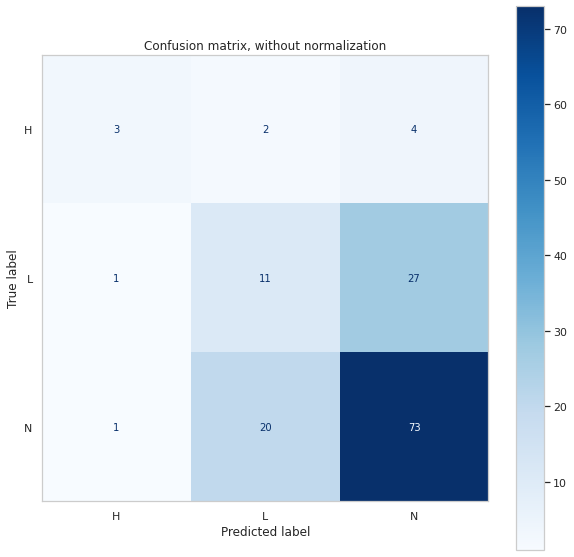

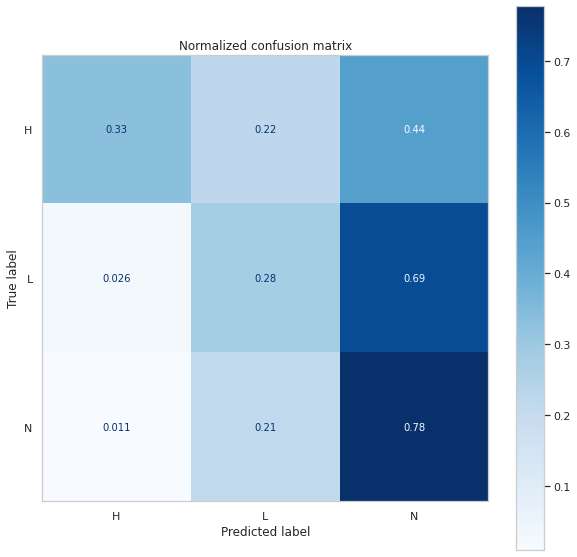

In [ ]:
# confusion matrix
class_names = le_name_map.keys()

titles_options = [
                  ("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", "true")
]

for title, normalize in titles_options:
  fig, ax = plt.subplots(figsize = (10, 10))

  disp = ConfusionMatrixDisplay.from_estimator(
      clf, X_eval, y_eval, display_labels = class_names, cmap = plt.cm.Blues,
      normalize = normalize, ax = ax
  )
  disp.ax_.set_title(title)
  disp.ax_.grid(False)

  print(title)
  print(disp.confusion_matrix)

+ N에 대한 예측이 다른 범주에 비해 꽤 많은편

In [ ]:
# classification report
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           H       0.33      0.60      0.43         5
           L       0.28      0.33      0.31        33
           N       0.78      0.70      0.74       104

    accuracy                           0.61       142
   macro avg       0.46      0.55      0.49       142
weighted avg       0.65      0.61      0.63       142



+ percision 정밀도 : 양성으로 예측한 결과 중 실제로 양성인 비율
+ recall 재현율 : 실제 양성 중에서 양성으로 올바르게 예측한 비율
+ F1 score : 정밀도와 재현율의 가중평균
+ support 지지도 : 각 범주에서의 발생 횟수

### Feature Importance

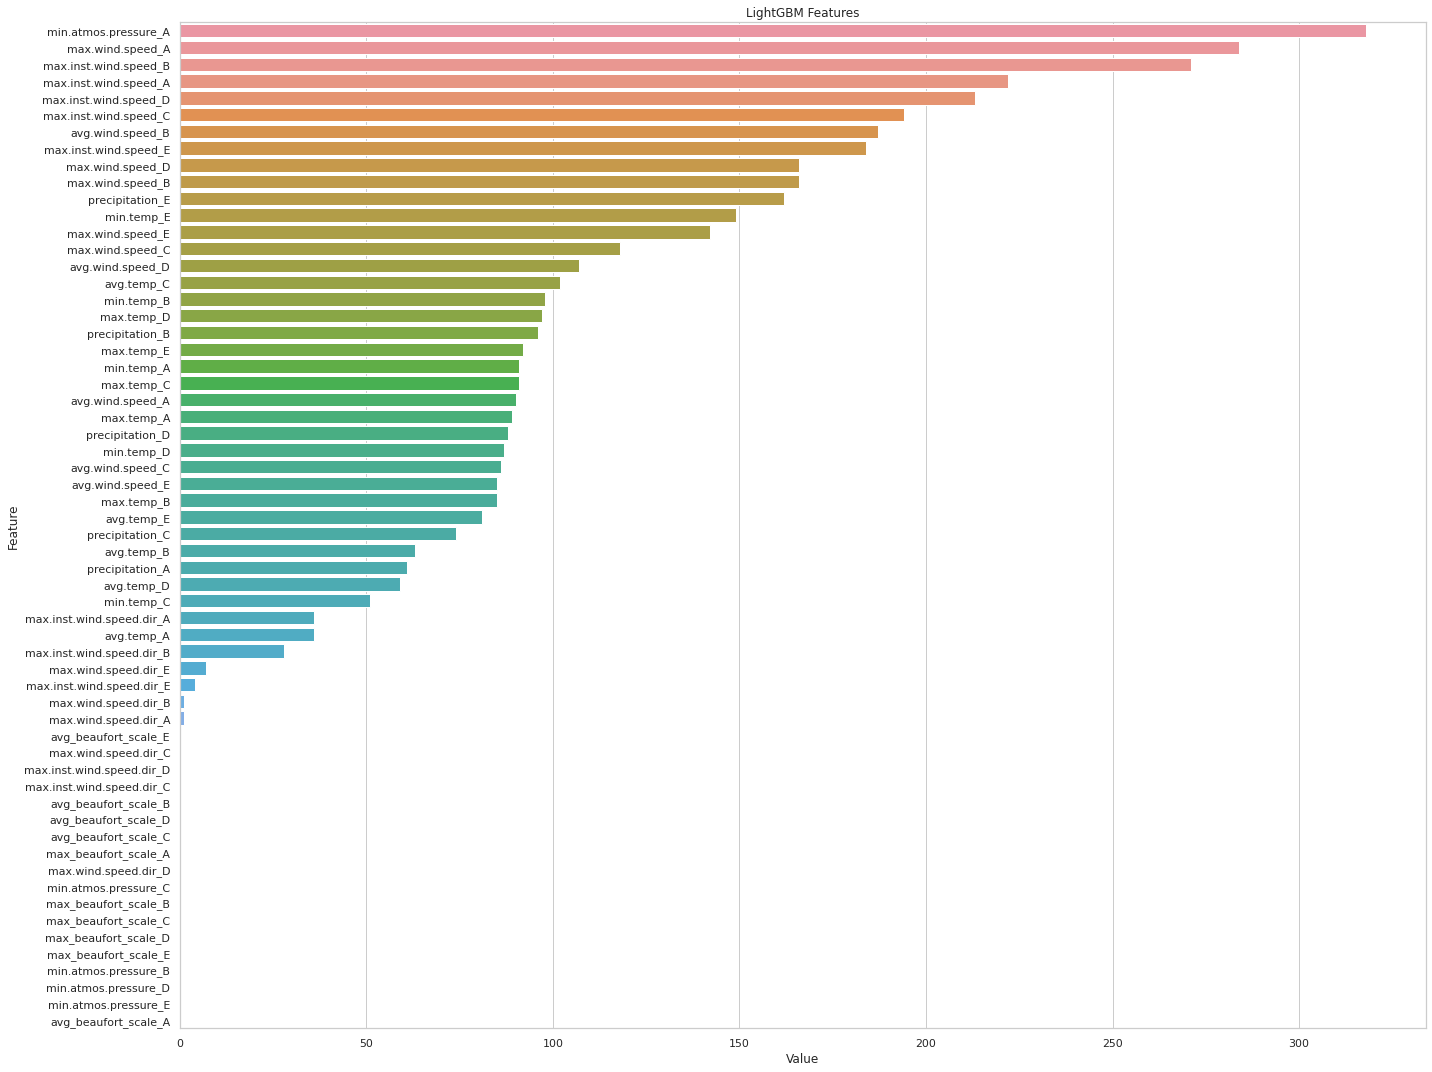

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns)), columns = ['Value', 'Feature'])

plt.figure(figsize = (20, 15))
sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
plt.title("LightGBM Features")
plt.tight_layout()

In [ ]:
# joblib.dump(clf, "lgb1.pk1")

### Predict on test data

In [ ]:
X = test.drop("date", axis = 1)

# Convert cat_features to pd.Categorical dtype
for col in cat_feats:
  X[col] = pd.Categorical(X[col])

In [ ]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns = ['label'])], axis = 1)
submission_df.head()

,date,label
0,0001f2fd,H
1,00177dc1,L
2,00b3a048,L
3,013f131b,N
4,01a1b150,N


In [ ]:
submission_df.to_csv("solution_2019015003.csv", index = False)